In [14]:
import json
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import torch, torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
import pickle

# For plotting
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [15]:
# === Graph Building and Feature Engineering ===

def build_graph_from_json(json_path):
    """
    Builds a heterogeneous graph from a JSON file of safari data.
    The graph contains two types of nodes: 'safari' and 'location'.
    Edges are created between safaris and their locations, and between safaris with shared tags.
    Features are a combination of numerical data, multi-hot encoded tags, and TF-IDF of descriptions.
    """
    def safe_float(val):
        try:
            return float(val.replace('° N','').replace('° S','').replace('° E','').replace('° W','').strip())
        except (ValueError, AttributeError):
            return 0.0
        
    # Add a new safe conversion function for the 'rating' and 'total_reviews' fields.
    def safe_convert(val, type_cast, default_val=0):
        try:
            # Handle 'N/A' and other non-numeric strings
            if isinstance(val, str):
                val = val.replace(',', '')
                if val.strip().lower() == 'n/a':
                    return default_val
            return type_cast(val)
        except (ValueError, AttributeError):
            return default_val

    data = json.load(open(json_path,'r',encoding='utf-8'))

    # Build node lists
    safari_nodes = data
    location_nodes = {}
    for s in safari_nodes:
        location_nodes.setdefault(s['extracted_features']['district'], None)

    # Map nodes to indices
    node_index = {}
    idx = 0
    safari_keys = []
    for s in safari_nodes:
        key = f"SAF:{s.get('id', s['title'])}"
        safari_keys.append(key)
        node_index[key] = idx; idx+=1
    for loc in location_nodes.keys():
        key = f"LOC:{loc}"
        node_index[key] = idx; idx+=1

    # Extract features for safaris
    lat, lon, rating, review_count = [], [], [], []
    descriptions, all_tags = [], []

    for s in safari_nodes:
        lat.append(safe_float(s['extracted_features'].get('latitude', '0')))
        lon.append(safe_float(s['extracted_features'].get('longitude', '0')))

        # Use the new safe_convert function for rating
        rating.append(safe_convert(s.get('rating', 0.0), float))
        
        # Use the new safe_convert function for review_count
        review_count.append(safe_convert(s.get('total_reviews', '0'), int))
        
        descriptions.append(s.get('description',''))
        all_tags.append(s.get('tags', []))

    # Normalize numeric features
    num_feats = np.vstack([lat, lon, rating, np.log1p(review_count)]).T
    scaler = StandardScaler()
    num_feats = scaler.fit_transform(num_feats)

    # Multi-hot encode tags
    # First, collect all unique tags from your full dataset
    all_unique_tags = set(tag for sublist in all_tags for tag in sublist)

    mlb = MultiLabelBinarizer(classes=sorted(list(all_unique_tags)))
    tag_feats = mlb.fit_transform(all_tags)

    # TF-IDF of descriptions
    vect = TfidfVectorizer(max_features=300)
    tfidf = vect.fit_transform(descriptions).toarray()

    # Combine features
    safari_feat = np.hstack([num_feats, tag_feats, tfidf])
    feat_dim = safari_feat.shape[1]

    # Build feature matrix for all nodes
    N = idx
    X = np.zeros((N, feat_dim), dtype=np.float32)
    for i, key in enumerate(safari_keys):
        X[node_index[key]] = safari_feat[i]

    # Location features (mean of safaris at that location)
    for loc in location_nodes.keys():
        key = f"LOC:{loc}"
        saf_idxs = [i for i, s in enumerate(safari_nodes) if s['extracted_features']['district'] == loc]
        if saf_idxs:
            X[node_index[key]] = safari_feat[saf_idxs].mean(axis=0)
        else:
            X[node_index[key]] = np.zeros(feat_dim)

    # Build edges
    edges = []
    for s in safari_nodes:
        s_key = f"SAF:{s.get('id', s['title'])}"
        loc_key = f"LOC:{s['extracted_features']['district']}"
        edges.append((node_index[s_key], node_index[loc_key]))
        edges.append((node_index[loc_key], node_index[s_key])) # bidirectional

    # Safari-safari edges by tag overlap
    for i,s1 in enumerate(safari_nodes):
        for j,s2 in enumerate(safari_nodes[i+1:], start=i+1):
            if s1.get('tags',[]) and s2.get('tags',[]) and set(s1['tags']) & set(s2['tags']):
                a = node_index[f"SAF:{s1.get('id', s1['title'])}"]
                b = node_index[f"SAF:{s2.get('id', s2['title'])}"]
                edges.append((a,b)); edges.append((b,a))

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    X = torch.tensor(X, dtype=torch.float)
    data = Data(x=X, edge_index=edge_index)

    return data, node_index, mlb, vect, scaler, safari_nodes

In [16]:
# === GNN Model and Training ===

class GCNLinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCNLinkPredictor, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

def decode(z, edge_index):
    z_src = z[edge_index[0]]
    z_dst = z[edge_index[1]]
    return (z_src * z_dst).sum(dim=1)

def compute_loss(z, edge_label_index, edge_label):
    """
    Computes the loss using the combined positive and negative edge samples
    provided by RandomLinkSplit.
    """
    scores = decode(z, edge_label_index)
    return F.binary_cross_entropy_with_logits(scores, edge_label)

def train_model(data, epochs=100):
    """
    Trains the GCNLinkPredictor model for link prediction.
    """
    # Use RandomLinkSplit for train/val/test splits
    transform = RandomLinkSplit(
        num_val=0.1, num_test=0.1, is_undirected=True
    )
    train_data, val_data, test_data = transform(data)

    model = GCNLinkPredictor(data.num_features, hidden_channels=64)
    # To add L2 regularization, change the optimizer in your train_model function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    train_fprs, train_tprs, val_fprs, val_tprs = [], [], [], []

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        z = model(train_data.x, train_data.edge_index)

        # The loss function now directly uses edge_label_index and edge_label
        loss = compute_loss(z, train_data.edge_label_index, train_data.edge_label)
        loss.backward()
        optimizer.step()

        # Intermediate results: calculate and store metrics
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                z_train = model(train_data.x, train_data.edge_index)
                train_scores = torch.sigmoid(decode(z_train, train_data.edge_label_index)).cpu().numpy()
                train_labels = train_data.edge_label.cpu().numpy()
                
                z_val = model(val_data.x, val_data.edge_index)
                val_scores = torch.sigmoid(decode(z_val, val_data.edge_label_index)).cpu().numpy()
                val_labels = val_data.edge_label.cpu().numpy()
                
                # Check if there are both positive and negative samples for ROC calculation
                if len(np.unique(train_labels)) > 1 and len(np.unique(val_labels)) > 1:
                    train_fpr, train_tpr, _ = roc_curve(train_labels, train_scores)
                    val_fpr, val_tpr, _ = roc_curve(val_labels, val_scores)
                    train_fprs.append(train_fpr); train_tprs.append(train_tpr)
                    val_fprs.append(val_fpr); val_tprs.append(val_tpr)
                    train_auc = roc_auc_score(train_labels, train_scores)
                    val_auc = roc_auc_score(val_labels, val_scores)
                    print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}")
                else:
                    print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")

    return model, train_data, val_data, test_data, (train_fprs, train_tprs, val_fprs, val_tprs)

def save_model_and_artifacts(model, node_index, mlb, vect, scaler, safari_nodes):
    """
    Saves the trained model and other necessary artifacts for future recommendations.
    """
    torch.save(model.state_dict(), 'gnn_model.pt')
    with open('model_artifacts.pkl', 'wb') as f:
        pickle.dump({
            'node_index': node_index,
            'mlb': mlb,
            'vect': vect,
            'scaler': scaler,
            'safari_nodes': safari_nodes
        }, f)
    print("✅ Model and artifacts saved!")

def load_model_and_artifacts(in_channels, hidden_channels=64):
    """
    Loads the trained model and artifacts from disk.
    """
    model = GCNLinkPredictor(in_channels, hidden_channels)
    model.load_state_dict(torch.load('gnn_model.pt'))
    model.eval()

    with open('model_artifacts.pkl', 'rb') as f:
        artifacts = pickle.load(f)

    return model, artifacts['node_index'], artifacts['mlb'], artifacts['vect'], artifacts['scaler'], artifacts['safari_nodes']


In [17]:

# === Recommendation Generation ===

def get_safari_recommendations(query_text, query_tags, num_recommendations, model, data, artifacts):
    """
    Generates safari recommendations based on a user query.
    """
    node_index = artifacts['node_index']
    mlb = artifacts['mlb']
    vect = artifacts['vect']
    scaler = artifacts['scaler']
    safari_nodes = artifacts['safari_nodes']

    # Get embeddings for all nodes in the graph
    with torch.no_grad():
        all_node_embeddings = model(data.x, data.edge_index)

    # Create a feature vector for the user query
    query_description_tfidf = vect.transform([query_text]).toarray()
    query_tags_mlb = mlb.transform([query_tags])
    
    # Placeholder for numerical features
    query_num_feats = scaler.transform(np.array([[0, 0, 0, 0]])) 
    
    query_features = np.hstack([query_num_feats, query_tags_mlb, query_description_tfidf])
    query_features_tensor = torch.tensor(query_features, dtype=torch.float)

    # Generate an embedding for the query using the GCN model
    # We pass an empty edge_index because the query is a single, isolated node
    query_embedding = model(query_features_tensor, torch.empty((2, 0), dtype=torch.long))

    # Get embeddings only for safari nodes
    safari_keys = [key for key in node_index.keys() if key.startswith("SAF:")]
    safari_indices = [node_index[key] for key in safari_keys]
    
    safari_embeddings = all_node_embeddings[safari_indices]

    # Calculate similarity between the query embedding and all safari embeddings
    similarities = F.cosine_similarity(query_embedding, safari_embeddings)

    # Get top recommendations
    top_indices = torch.topk(similarities, k=num_recommendations).indices.tolist()
    
    recommended_safaris = [safari_nodes[i] for i in top_indices]
    
    return recommended_safaris

--- 1. Building the graph and extracting features ---

--- 2. Training the model and saving artifacts ---
Epoch 010, Loss: 0.3894, Train AUC: 0.9986, Val AUC: 0.9869
Epoch 020, Loss: 0.3585, Train AUC: 0.9989, Val AUC: 0.9483
Epoch 030, Loss: 0.3289, Train AUC: 0.9998, Val AUC: 0.8540
Epoch 040, Loss: 0.2934, Train AUC: 0.9997, Val AUC: 0.7812
Epoch 050, Loss: 0.2542, Train AUC: 0.9999, Val AUC: 0.7483
Epoch 060, Loss: 0.2308, Train AUC: 1.0000, Val AUC: 0.7402
Epoch 070, Loss: 0.2002, Train AUC: 0.9999, Val AUC: 0.7231
Epoch 080, Loss: 0.1776, Train AUC: 0.9999, Val AUC: 0.7146
Epoch 090, Loss: 0.1577, Train AUC: 0.9999, Val AUC: 0.7110
Epoch 100, Loss: 0.1392, Train AUC: 1.0000, Val AUC: 0.7252
✅ Model and artifacts saved!

--- 2.1 Plotting ROC Curves ---


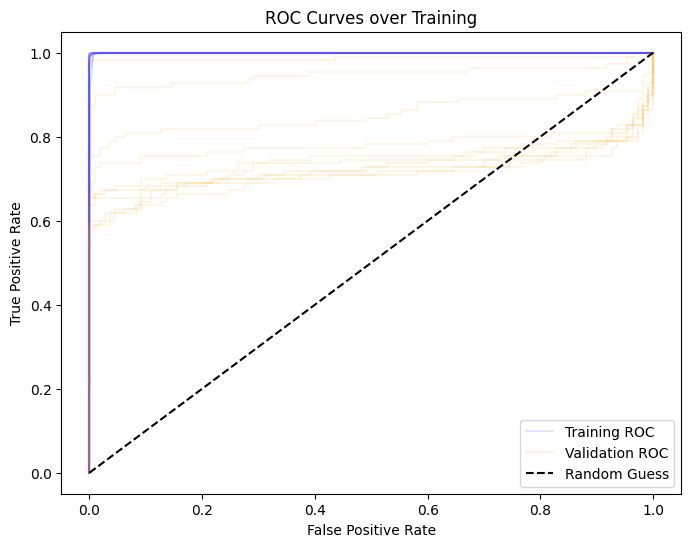


--- 3. Visualizing the Graph ---


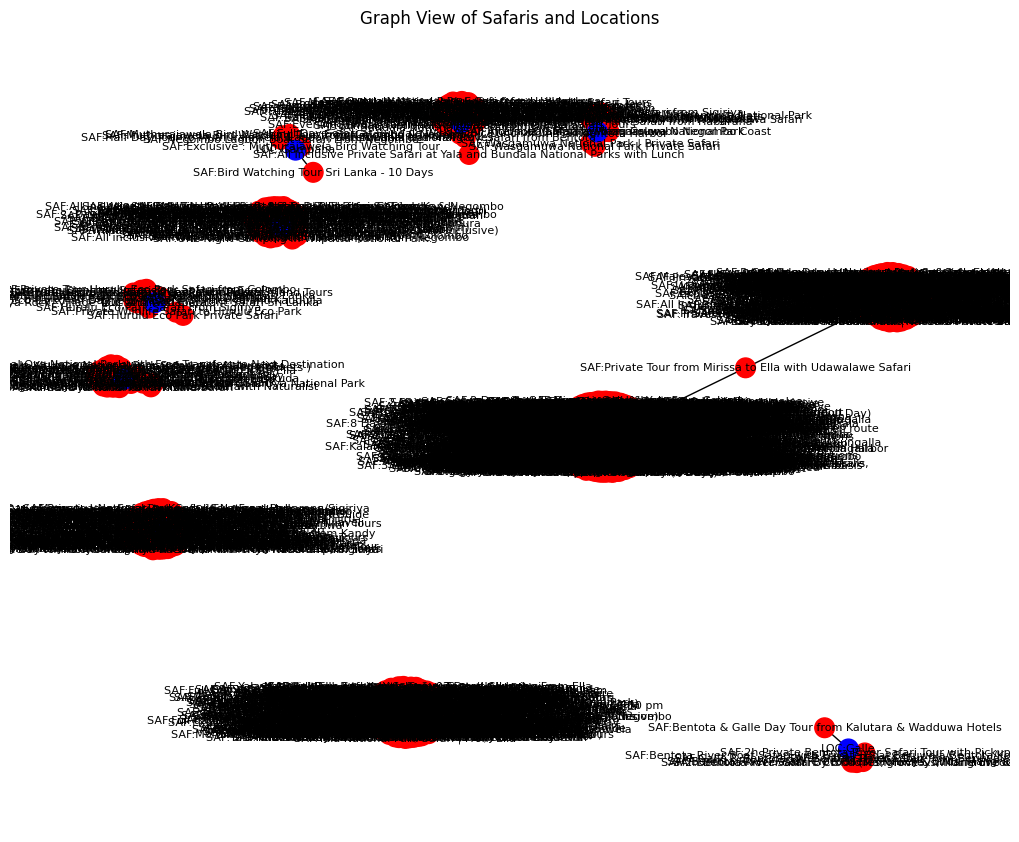

C:\Users\thara\AppData\Local\Temp\ipykernel_26188\4041733016.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('gnn_model.pt'))
d:\Proje


--- Recommendations for your query ---
1. Udawalawe Jeep Safari from Kalutara & Wadduwa Hotels (Rating: N/A)
2. Sigiriya Fortress and Habarana Safari, Day Tour from Colombo (Rating: N/A)
3. Udawalawe National Park Private Safari (Rating: 3.7)
4. Private Trip Buduruwagala and Udawalawe Safari from Tangalle (Rating: N/A)
5. 04 day Sri Lanka Beach, Wildlife Tour & Colombo city tour (Rating: N/A)


In [18]:

# === Main Execution ===
if __name__ == "__main__":
    json_path = "sri_lanka_safari_feature_extracted.json"
    
    # 1. Build the graph and extract features
    print("--- 1. Building the graph and extracting features ---")
    data, node_index, mlb, vect, scaler, safari_nodes = build_graph_from_json(json_path)

    # 2. Train the model and save artifacts
    print("\n--- 2. Training the model and saving artifacts ---")
    model, _, val_data, _, (train_fprs, train_tprs, val_fprs, val_tprs) = train_model(data, epochs=100)
    save_model_and_artifacts(model, node_index, mlb, vect, scaler, safari_nodes)

    # 2.1 Plotting ROC curves
    print("\n--- 2.1 Plotting ROC Curves ---")
    plt.figure(figsize=(8, 6))
    for i in range(len(train_fprs)):
        plt.plot(train_fprs[i], train_tprs[i], color='blue', alpha=0.1, label='Training ROC' if i == 0 else "")
        plt.plot(val_fprs[i], val_tprs[i], color='orange', alpha=0.1, label='Validation ROC' if i == 0 else "")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves over Training')
    plt.legend()
    plt.show()

    print("\n--- 3. Visualizing the Graph ---")
    G = nx.Graph()
    for i, (key, idx) in enumerate(node_index.items()):
        G.add_node(idx, label=key, node_type=key.split(':')[0])

    for i in range(data.edge_index.size(1)):
        source, target = data.edge_index[0, i].item(), data.edge_index[1, i].item()
        G.add_edge(source, target)

    pos = nx.spring_layout(G)
    node_colors = ['red' if G.nodes[node]['node_type'] == 'SAF' else 'blue' for node in G.nodes]
    node_labels = {node: data['label'] for node, data in G.nodes(data=True)}
    
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color=node_colors, node_size=200, font_size=8)
    plt.title('Graph View of Safaris and Locations')
    plt.show()

    # 3. Load the model and artifacts
    loaded_model, loaded_node_index, loaded_mlb, loaded_vect, loaded_scaler, loaded_safari_nodes = load_model_and_artifacts(data.num_features)
    
    # 4. Generate recommendations for a sample query
    query_text = "elephant watching"
    query_tags = ["Elephants"]
    num_recommendations = 5
    
    recommendations = get_safari_recommendations(
        query_text, 
        query_tags, 
        num_recommendations, 
        loaded_model, 
        data, # Pass the data object here
        {'node_index': loaded_node_index, 'mlb': loaded_mlb, 'vect': loaded_vect, 'scaler': loaded_scaler, 'safari_nodes': loaded_safari_nodes}
    )
    
    print("\n--- Recommendations for your query ---")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec['title']} (Rating: {rec['rating']})")

In [19]:
# 4. Generate recommendations for a sample query
query_text = "leopards"
query_tags = ["leopards"]
num_recommendations = 5
    
recommendations = get_safari_recommendations(
    query_text, 
    query_tags, 
    num_recommendations, 
    loaded_model, 
    data, # Pass the data object here
    {'node_index': loaded_node_index, 'mlb': loaded_mlb, 'vect': loaded_vect, 'scaler': loaded_scaler, 'safari_nodes': loaded_safari_nodes}
)
    
print("\n--- Recommendations for your query ---")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['title']} (Rating: {rec['rating']})")


--- Recommendations for your query ---
1. All Inclusive Yala National Park Full Day Safari (Rating: N/A)
2. Udawalawe Safari Jeep Tour (Rating: N/A)
3. 13 Days Sri Lanka Tour - Small Miracle (Rating: N/A)
4. Safari Tour at Minneriya National Park (Rating: 4.9)
5. Private Tour Udawalawe National Park Full Day from Colombo (Rating: N/A)


d:\Projects\Project-RoadmapGenerationModel\venv\lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['leopards'] will be ignored
  warnings.warn(
